In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import src.fitting as fitting
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

In [8]:
datapath = '/Volumes/Lab/Users/praful/Vasireddy2025/data'
dataset = '2020-10-18-0'
p = 233
c = 85

data = loadmat(os.path.join(datapath, f'fit_{dataset}_p{p}c{c}.mat'))

Number of sites: 1, Test R2: -3.980301136571544
Number of sites: 2, Test R2: 0.5793776894952571
Number of sites: 3, Test R2: 0.7039367550495212
Number of sites: 4, Test R2: 0.7339599362430862
Number of sites: 5, Test R2: 0.734982439858668


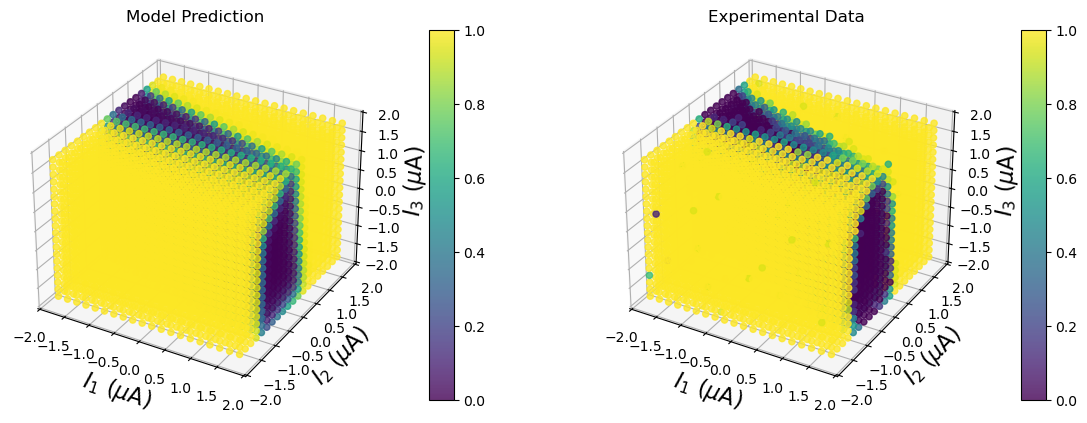

In [9]:
probs_flipped = data['probs'].flatten()
amps_gsort = data['amps']
num_trials = data['trials'].flatten()

ms = [1, 2, 3, 4, 5]
zero_prob = 0.01
slope_bound = 100
R2_thresh = 0.025
reg_param = 0.5
method = 'L-BFGS-B'
reg_method = 'l2'

w_inits = []
for m in ms:
    w_init = np.array(np.random.normal(size=(m, amps_gsort.shape[1]+1)))
    z = 1 - (1 - zero_prob)**(1/len(w_init))
    w_init[:, 0] = np.clip(w_init[:, 0], None, np.log(z/(1-z)))
    w_init[:, 1:] = np.clip(w_init[:, 1:], -slope_bound, slope_bound)
    w_inits.append(w_init)

opt, _ = fitting.fit_surface_earlystop(amps_gsort, probs_flipped, num_trials, w_inits,
                            reg_method=reg_method, reg=reg_param, slope_bound=slope_bound,
                            zero_prob=zero_prob, method=method,
                            R2_thresh=R2_thresh                           
)
params_fit, _, _ = opt
probs_pred = fitting.sigmoidND_nonlinear(sm.add_constant(amps_gsort, has_constant='add'), 
                                         params_fit)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')  # Create a 3D subplot

# Set labels and limits
ax.set_xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
ax.set_ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)
ax.set_title('Model Prediction')

# Scatter plot
scat = ax.scatter(amps_gsort[:, 0], amps_gsort[:, 1], amps_gsort[:, 2], marker='o', 
                c=probs_pred, s=20, alpha=0.8,
                vmin=0, vmax=1)

# Add color bar
cbar = fig.colorbar(scat, ax=ax, shrink=0.8, aspect=15, pad=0.1)

# Panel 2: Subsampled selectivity
ax2 = fig.add_subplot(122, projection='3d')
scat2 = ax2.scatter(amps_gsort[:, 0], amps_gsort[:, 1], amps_gsort[:, 2],
                    c=probs_flipped, marker='o', s=20, alpha=0.8, vmin=0, vmax=1)
ax2.set_xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
ax2.set_ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
ax2.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)
ax2.set_title('Experimental Data')
cbar2 = fig.colorbar(scat2, ax=ax2, shrink=0.8, aspect=15, pad=0.1)
plt.show()